# Generating Masks and Presence Predictions

### Imports

In [1]:
if 'NOTEBOOK_INITIATED_FLAG' not in globals():
    NOTEBOOK_INITIATED_FLAG = True
    %cd ..
%pwd

import os
import numpy             as np
import matplotlib.pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

plt.rcParams['figure.figsize']  = (16,8)

from tensorflow.keras.models import load_model
from osgeo                   import gdal
from PIL                     import Image
from src.io                  import get_image_array
from src.inference           import mask_with_model, mask_simulated
from src.sarsim              import gen_simulated_deformation, gen_sim_noise

/home/andrew/repos/AI-Event-Monitoring


In [2]:
def plot_results(wrapped, mask, presence_mask):

    _, [axs_wrapped, axs_mask, axs_presence_mask] = plt.subplots(1, 3)

    axs_wrapped.set_title('Wrapped')
    axs_mask.set_title('Segmentation Mask')
    axs_presence_mask.set_title('Presence Mask')
    
    axs_wrapped.imshow(wrapped, origin='lower', cmap='jet')
    axs_mask.imshow(mask, origin='lower', cmap='jet')
    axs_presence_mask.imshow(presence_mask, origin='lower', cmap='jet')

### Inference on a Single Wrapped or Unwrapped Image

In [6]:
tile_size = 512
crop_size = 512

mask_model_path = 'data/output/models/checkpoints/masking_modelV1'
pres_model_path = 'data/output/models/checkpoints/classification_modelV31'
image_path      = '../../data/S1AB_20171111T150004_20171117T145926_VVP006_INT80_G_ueF_36B1/S1AB_20171111T150004_20171117T145926_VVP006_INT80_G_ueF_36B1_unw_phase.tif'
output_path     = '3741_mask.tif'

mask_model = load_model(mask_model_path)
pres_model = load_model(pres_model_path)

is_wrapped = True

if is_wrapped:
    wrapped, gdal_dataset = get_image_array(image_path)
else:
    unwrapped, gdal_dataset = get_image_array(image_path)
    wrapped      = np.angle(np.exp(1j * (unwrapped)))

In [7]:
mask, presence_mask, presence_values = mask_with_model(
    mask_model = mask_model,
    pres_model = pres_model,
    arr_w      = wrapped,
    tile_size  = tile_size,
    crop_size  = crop_size
)

Positive!


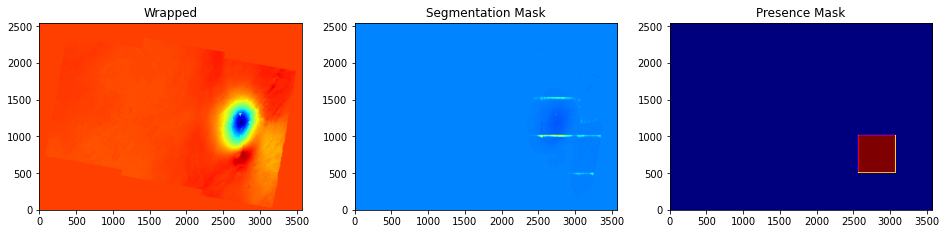

In [8]:
if np.max(presence_values) > 0.7:
    print("Positive!")
else:
    print("Negative!")

mask[wrapped == 0] = 0

plot_results(wrapped, mask, presence_mask)

In [12]:
output_img = Image.fromarray(mask)
output_img.save(output_path)

out_dataset = gdal.Open(output_path, gdal.GA_Update)
out_dataset.SetProjection(gdal_dataset.GetProjection())
out_dataset.SetGeoTransform(gdal_dataset.GetGeoTransform())
out_dataset.FlushCache()